<a href="https://colab.research.google.com/github/Andrey-Epifanov-k721/conv_networks/blob/master/DPD_in_Pytorch_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Это блокнот обучения нейронной сети на Pythorch для задачи линеаризации УМ.



# Загрузка и подготовка данных

In [619]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

import torch
import torch.nn as nn
import torch.optim as optim

In [620]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import math

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [621]:
# входной файл с данными
Re_array_AM_AM_and_AM_PH_corrected = pd.read_csv('Re_array_AM_AM_and_AM_PH_corrected.csv',delimiter = ',', names = ['A'])
Re_corrected = np.array(Re_array_AM_AM_and_AM_PH_corrected).reshape(-1, )

Im_array_AM_AM_and_AM_PH_corrected = pd.read_csv('Im_array_AM_AM_and_AM_PH_corrected.csv',delimiter = ',', names = ['A'])
Im_corrected = np.array(Im_array_AM_AM_and_AM_PH_corrected).reshape(-1, )


RE_array_NN_input = 'RE_array_paInput.txt'
# RE_array_NN_input = np.loadtxt(RE_array_NN_input, delimiter='\n')
RE_array_NN_input = np.loadtxt(RE_array_NN_input, delimiter=None)

IM_array_NN_input = 'IM_array_paInput.txt'
# IM_array_NN_input = np.loadtxt(IM_array_NN_input, delimiter='\n')
IM_array_NN_input = np.loadtxt(IM_array_NN_input, delimiter=None)

# Загрузим массив входных в ИНС значений амплитуд
input_NN_amplitudes = 'input_NN_amplitudes.txt'
# input_NN_amplitudes = np.loadtxt(input_NN_amplitudes, delimiter='\n')
input_NN_amplitudes = np.loadtxt(input_NN_amplitudes, delimiter=None)

# Загрузим массив-учитель целевых выходных из ИНС значений амплитуд
goal_output_NN_amplitudes = 'goal_output_NN_amplitudes.txt'
# goal_output_NN_amplitudes = np.loadtxt(goal_output_NN_amplitudes, delimiter='\n')
goal_output_NN_amplitudes = np.loadtxt(goal_output_NN_amplitudes, delimiter=None)

# Загрузим файл с значениями весов для каждого отсчета. Это нужно чтобы учесть
# неравномерность данных. В последствии при обучении ИНС этот массив будет подан в функцию
# fit как параметр loss_weights.
array_sample_weight = pd.read_csv('array_sample_weight.csv',delimiter = ',', names = ['A'])
array_sample_weight = array_sample_weight.to_numpy().ravel()

# Загрузим массив точек разницы между input и линейным откликом LINE_POINT_y (коэф усиления учтен)
DPD_y_point_no_gain = 'DPD_y_point_no_gain.txt'
DPD_y_point_no_gain = np.loadtxt(DPD_y_point_no_gain, delimiter=None)

In [622]:
# создадим датафрейм
data = {'RE_array_NN_input': RE_array_NN_input, 'IM_array_NN_input': IM_array_NN_input,
        'Re_corrected': Re_corrected, 'Im_corrected': Im_corrected, 'DPD_y_point_no_gain': DPD_y_point_no_gain,
        'array_sample_weight': array_sample_weight}
df = pd.DataFrame(data)

inp = ['RE_array_NN_input', 'IM_array_NN_input']
outp = ['Re_corrected', 'Im_corrected']
helper_spectrum = ['DPD_y_point_no_gain']
array_sample_weight = ['array_sample_weight']

input_data = df[inp].values
targets_data = df[outp].values
y_points_DPD_minus_input = df[helper_spectrum].values
array_sample_weight = df[array_sample_weight].values

trains = np.array(input_data)
targets = np.array(targets_data)
y_points_DPD_minus_input = np.array(y_points_DPD_minus_input)
array_sample_weight = np.array(array_sample_weight)

**Глобальные переменные**

In [623]:
memory_size = 5
length = len(input_data)

In [624]:
def get_batch(trains, targets, start_index, end_index, memory_size):

    data = []
    labels = []

    start_index = start_index + memory_size

    if end_index is None:
        end_index = len(trains) - memory_size

    for i in range(start_index, end_index):         # от 0 до len(input_NN_amplitudes)
        indices = range(i, i + memory_size)         #
        data.append(trains[indices])

        labels.append(targets[i + memory_size - 1])
        # labels.append(targets[i:i + memory_size])

    return np.array(data), np.array(labels)

In [625]:
#
a = get_batch(trains, targets, 0, (length-memory_size), memory_size)
b = get_batch(y_points_DPD_minus_input, targets, 0, (length-memory_size), memory_size)
c = get_batch(array_sample_weight, targets, 0, (length-memory_size), memory_size)

batch_trains = a[0]
batch_targets = a[1]
print('batch_trains: ', batch_trains[3904], batch_trains.shape)
print('batch_targets: ', batch_targets[3904], batch_targets.shape)
print('batch_trains shape: ', batch_trains.shape, 'type: ', type(batch_trains))
print('batch_targets shape: ', batch_targets.shape, 'type: ', type(batch_targets))

batch_y_points = b[0]
sample_weight = c[0]
print('batch_y_points: ', batch_y_points[3904], batch_y_points.shape, len(batch_y_points))
print('sample_weight: ', sample_weight[3904], sample_weight.shape, len(sample_weight))

batch_trains:  [[ 0.9596232 -0.687106 ]
 [ 0.9554261 -1.059925 ]
 [ 0.8938059 -1.397726 ]
 [ 0.777939  -1.674693 ]
 [ 0.6151273 -1.869359 ]] (48374, 5, 2)
batch_targets:  [ 0.79790926 -1.82224288] (48374, 2)
batch_trains shape:  (48374, 5, 2) type:  <class 'numpy.ndarray'>
batch_targets shape:  (48374, 2) type:  <class 'numpy.ndarray'>
batch_y_points:  [[0.06243585]
 [0.04806071]
 [0.01431686]
 [0.00335856]
 [0.02155662]] (48374, 5, 1) 48374
sample_weight:  [[0.1]
 [0.1]
 [0.3]
 [0.3]
 [1. ]] (48374, 5, 1) 48374


In [626]:
# разделим данные на тренировочный и проверочный наборы

# Процент данных для проверки (например, 20%)
validation_percent = 0.1

# Вычисление количества данных для проверки
num_validation_samples = int(batch_trains.shape[0] * validation_percent)

# Разделение на тренировочные и проверочные данные
train_indices = np.arange(num_validation_samples, batch_trains.shape[0])
validation_indices = np.arange(num_validation_samples)


tr_trains = torch.tensor(batch_trains[train_indices], dtype=torch.float32)
tr_targets = torch.tensor(batch_targets[train_indices], dtype=torch.float32)

val_trains = torch.tensor(batch_trains[validation_indices], dtype=torch.float32)
val_targets = torch.tensor(batch_targets[validation_indices], dtype=torch.float32)


y_points_trains = torch.tensor(batch_y_points[train_indices], dtype=torch.float32)
sample_weight = torch.tensor(sample_weight[train_indices], dtype=torch.float32)

# переназначение
# tr_trains = tr_trains[:43008]
# tr_targets = tr_targets[:43008]
# val_trains = val_trains[:43008]
# val_targets = val_targets[:43008]
# y_points_trains = y_points_trains[:43008]
# sample_weight = sample_weight[:43008]

# Вывод размеров полученных данных
print("Размеры тренировочных данных (tr_trains, tr_targets):", tr_trains.shape, tr_targets.shape, "type", type(tr_trains))
print("Размеры проверочных данных (val_trains, val_targets):", val_trains.shape, val_targets.shape, "type", type(val_trains))
print("Размеры данных y_points_trains - данные для получания линейного отклика:", y_points_trains.shape, y_points_trains.shape, "type", type(y_points_trains))
print("Размеры данных sample_weight - данные для получания линейного отклика:", sample_weight.shape, sample_weight.shape, "type", type(sample_weight))

Размеры тренировочных данных (tr_trains, tr_targets): torch.Size([43537, 5, 2]) torch.Size([43537, 2]) type <class 'torch.Tensor'>
Размеры проверочных данных (val_trains, val_targets): torch.Size([4837, 5, 2]) torch.Size([4837, 2]) type <class 'torch.Tensor'>
Размеры данных y_points_trains - данные для получания линейного отклика: torch.Size([43537, 5, 1]) torch.Size([43537, 5, 1]) type <class 'torch.Tensor'>
Размеры данных sample_weight - данные для получания линейного отклика: torch.Size([43537, 5, 1]) torch.Size([43537, 5, 1]) type <class 'torch.Tensor'>


In [627]:
# Обернем полученные из get_batch батчи в еще одни батчи.
# Эту нужно для того чтобы в цикле обучения шаг оптимизации не совершался каждый
# раз, когда сеть предсказывает всего-лишь два значения не выходе и для всего
# двух значений выполняется расчет градиентов и обновление весов

# Теперь сеть будет предсказывать 2*batch_size значений на выходе.
# Получается что обучение будет чуть быстрее.
# Кроме того, от значения batch_size будет зависеть расчет спектра сигнала
# Как показал эксперимент нужно чтобы количество точек было большим (128 - 1024)
# Одно предсказание сети Re Im это одно комплексное значение. Значит размер
# batch_size и будет являться количеством точек для расчета спектра в функции
# потерь

# Создание TensorDataset
tr_dataset = TensorDataset(tr_trains, tr_targets, y_points_trains, sample_weight)
val_dataset = TensorDataset(val_trains, val_targets)


# Создание DataLoader
batch_size = 32  # Установите подходящий размер пакета 43537

tr_dataloader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print("Размеры тренировочных данных (tr_dataloader):", '     ', len(tr_dataloader), "type: ", type(tr_dataloader))
print("Размеры проверочных данных (val_dataloader):",  '      ', len(val_dataloader), "type: ", type(val_dataloader))

Размеры тренировочных данных (tr_dataloader):       1361 type:  <class 'torch.utils.data.dataloader.DataLoader'>
Размеры проверочных данных (val_dataloader):        152 type:  <class 'torch.utils.data.dataloader.DataLoader'>


# Расчет функции потерь

In [628]:
def mean_squared_error(y_true, y_pred):
    """
    Расчет среднеквадратичной ошибки (MSE) между y_true и y_pred.
    """
    return torch.mean((y_true - y_pred) ** 2)

In [629]:
# def read_complex_data(file_path_re, file_path_im):
#     with open(file_path_re, 'r') as file_re, open(file_path_im, 'r') as file_im:
#         re_data = np.array([float(line.strip()) for line in file_re.readlines()])
#         im_data = np.array([float(line.strip()) for line in file_im.readlines()])
#         complex_data = re_data + 1j * im_data
#         print(complex_data)
#     return complex_data

In [630]:
# Укажите путь к файлам с Re и Im частями сигнала
file_path_re_i = "RE_array_paInput.txt"
file_path_im_i = "IM_array_paInput.txt"

file_path_re_o = "RE_array_paOutput.txt"
file_path_im_o = "IM_array_paOutput.txt"

In [631]:
# def calculate_spectrum(data):
#     spectrum = torch.fft.fft(data)
#     return spectrum

In [632]:
# def calculate_spectrum(data, n_fft=512, hop_length=64):
#     # data = data.unsqueeze(0).unsqueeze(0)
#     print("data: ", data.shape, len(data))
#     specgram = torch.stft(data, n_fft=n_fft, hop_length=hop_length, window=torch.hann_window(n_fft))
#     return specgram

In [633]:
def calculate_spectrum(data, n_fft=512, hop_length=64):

    target_num_segments = 43008  # Желаемое количество временных сегментов
    n_fft = (data.shape[0] - 1) // (target_num_segments - 1)  # Вычисляем n_fft
    hop_length = n_fft // 2  # Вычисляем hop_length

    # Вычисляем длину выходных данных STFT по формуле
    num_segments = 1 + (data.shape[0] - n_fft) // hop_length

    # Рассчитываем дополнительное количество отсчетов для увеличения размера
    extra_samples = (num_segments - 1) * hop_length + n_fft - data.shape[0]

    # Дополняем входные данные нулями
    padded_data = torch.cat((data, torch.zeros(extra_samples)))

    # Вычисляем спектрограмму
    specgram = torch.stft(padded_data, n_fft=n_fft, hop_length=hop_length, window=torch.hann_window(n_fft))

    print("Размер выходных данных STFT: ", specgram.shape)  # Размер выходных данных STFT
    return specgram

In [634]:
def calculate_spectrum(data, n_fft=512, hop_length=64):
    target_num_samples = 43008  # Желаемое количество отсчетов в выходной спектрограмме
    n_fft = (data.shape[0] - target_num_samples) * 2  # Вычисляем n_fft
    hop_length = n_fft // 2  # Вычисляем hop_length

    # Вычисляем количество временных сегментов
    num_segments = 1 + (data.shape[0] - n_fft) // hop_length

    # Рассчитываем дополнительное количество отсчетов для увеличения размера
    extra_samples = (num_segments - 1) * hop_length + n_fft - data.shape[0]

    # Дополняем входные данные нулями
    padded_data = torch.cat((data, torch.zeros(extra_samples)))

    # Вычисляем спектрограмму
    specgram = torch.stft(padded_data, n_fft=n_fft, hop_length=hop_length, window=torch.hann_window(n_fft))
    print("Размер выходных данных STFT: ", specgram.shape)  # Размер выходных данных STFT
    return specgram

In [635]:
# def plot_spectrum(spectrum, sampling_rate=100000000, title='Спектральная плотность'):
#     # print('plot spectrum: ', spectrum, type(spectrum))
#     # Вычисляем амплитуды в дБ
#     amplitudes_db = 20 * np.log10(np.abs(spectrum))
#     # Вычисляем частоты для оси x
#     freqs = np.fft.fftfreq(len(spectrum), d=1 / sampling_rate)

#     # Отображаем спектр на графике в логарифмическом масштабе (в дБ)
#     plt.plot(freqs, amplitudes_db)
#     plt.xlabel('Частота (Гц)')
#     plt.ylabel('Pвых (дБм)')
#     plt.title(title)
#     plt.grid(True)
#     plt.show()

In [636]:
# def plot_spectrum(spectrum, num_frequency_bands=48374//10, sampling_rate=100000000, title='Спектральная плотность'):
#     spectrum_np = torch.abs(spectrum).cpu().numpy()  # Convert to NumPy array
#     freq_band_size = len(spectrum_np) // num_frequency_bands
#     avg_amplitudes = []

#     for i in range(num_frequency_bands):
#         start_idx = i * freq_band_size
#         end_idx = (i + 1) * freq_band_size
#         avg_amplitude = np.mean(spectrum_np[start_idx:end_idx])
#         avg_amplitudes.append(avg_amplitude)

#     freqs = np.fft.fftfreq(len(avg_amplitudes), d=1 / sampling_rate)

#     plt.plot(freqs, 20 * np.log10(avg_amplitudes))  # Apply log scale to amplitudes
#     plt.xlabel('Частота (Гц)')
#     plt.ylabel('Усредненная амплитуда (дБ)')
#     plt.title(title)
#     plt.grid(True)
#     plt.show()

In [637]:
# def plot_spectrum(spectrum, num_frequency_bands=48374//10, sampling_rate=100000000, title='Спектральная плотность', vertical_lines=[-1.77e7, -0.59e7, 0.59e7, 1.77e7]):
#     spectrum_np = torch.abs(spectrum).cpu().numpy()  # Convert to NumPy array
#     freq_band_size = len(spectrum_np) // num_frequency_bands
#     avg_amplitudes = []

#     for i in range(num_frequency_bands):
#         start_idx = i * freq_band_size
#         end_idx = (i + 1) * freq_band_size
#         avg_amplitude = np.mean(spectrum_np[start_idx:end_idx])
#         avg_amplitudes.append(avg_amplitude)

#     freqs = np.fft.fftfreq(len(avg_amplitudes), d=1 / sampling_rate)

#     amplitudes_db = 20 * np.log10(np.abs(avg_amplitudes))

#     plt.plot(freqs, amplitudes_db)  # Apply log scale to amplitudes
#     plt.xlabel('Частота (Гц)')
#     plt.ylabel('Усредненная амплитуда (дБ)')
#     plt.title(title)
#     plt.grid(True)

#     if vertical_lines is not None:
#         for line in vertical_lines:
#             plt.axvline(x=line, color='red', linestyle='--')

#     plt.show()

In [638]:
# def plot_spectrum(spectrum, num_frequency_bands=48374//10, sampling_rate=100000000, title='Спектральная плотность', vertical_lines=[-1.77e7, -0.59e7, 0.59e7, 1.77e7]):
#     spectrum_np = torch.abs(spectrum).cpu().numpy()  # Convert to NumPy array
#     freq_band_size = len(spectrum_np) // num_frequency_bands
#     avg_amplitudes = []

#     for i in range(num_frequency_bands):
#         start_idx = i * freq_band_size
#         end_idx = (i + 1) * freq_band_size
#         avg_amplitude = np.mean(spectrum_np[start_idx:end_idx])
#         avg_amplitudes.append(avg_amplitude)

#     freqs = np.fft.fftfreq(len(avg_amplitudes), d=1 / sampling_rate)

#     amplitudes_db = 20 * np.log10(np.abs(avg_amplitudes))

#     plt.plot(freqs, amplitudes_db)  # Apply log scale to amplitudes
#     plt.xlabel('Частота (Гц)')
#     plt.ylabel('Усредненная амплитуда (дБ)')
#     plt.title(title)
#     plt.grid(True)

#     if vertical_lines is not None:
#         for line in vertical_lines:
#             plt.axvline(x=line, color='red', linestyle='--')

#         for interval in [(-1.77e7, -0.59e7), (-0.59e7, 0.59e7), (0.59e7, 1.77e7)]:
#             interval_indices = np.where((freqs >= interval[0]) & (freqs <= interval[1]))[0]

#             if len(interval_indices) > 0:
#                 avg_value = np.mean(amplitudes_db[interval_indices])
#                 avg_freq = np.mean(freqs[interval_indices])

#                 plt.annotate(f'{avg_value:.2f} дБ', (avg_freq, avg_value), textcoords="offset points", xytext=(-20,10), ha='center', fontsize=8, color='red')
#                 plt.plot(avg_freq, avg_value, 'ro')  # Отмечаем точку на графике

#     plt.show()

In [639]:
def plot_spectrum(spectrum, num_frequency_bands=48374//80, sampling_rate=100000000, title='Спектральная плотность', vertical_lines=[-1.77e7, -0.59e7, 0.59e7, 1.77e7]):
    spectrum_np = torch.abs(spectrum).cpu().numpy()  # Convert to NumPy array
    freq_band_size = len(spectrum_np) // num_frequency_bands
    avg_amplitudes = []

    for i in range(num_frequency_bands):
        start_idx = i * freq_band_size
        end_idx = (i + 1) * freq_band_size
        avg_amplitude = np.mean(spectrum_np[start_idx:end_idx])
        avg_amplitudes.append(avg_amplitude)

    freqs = np.fft.fftfreq(len(avg_amplitudes), d=1 / sampling_rate)

    amplitudes_db = 20 * np.log10(np.abs(avg_amplitudes))

    plt.plot(freqs, amplitudes_db)  # Apply log scale to amplitudes
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Усредненная амплитуда (дБ)')
    plt.title(title)
    plt.grid(True)

    if vertical_lines is not None:
        for line in vertical_lines:
            plt.axvline(x=line, color='red', linestyle='--')

        for interval_idx, interval in enumerate([(-1.77e7, -0.59e7), (-0.59e7, 0.59e7), (0.59e7, 1.77e7)]):
            interval_indices = np.where((freqs >= interval[0]) & (freqs <= interval[1]))[0]

            if len(interval_indices) > 0:
                avg_value = np.mean(amplitudes_db[interval_indices])
                avg_freq = np.mean(freqs[interval_indices])

                if interval_idx == 0:
                    left_interval_indices = np.where(freqs <= interval[0])[0]
                    right_interval_indices = np.where(freqs >= interval[1])[0]

                    if len(right_interval_indices) > 0:
                        diff_value_left = avg_value - amplitudes_db[right_interval_indices][0]
                        plt.annotate(f'Avg: {avg_value:.2f} дБ\nDiff L: {diff_value_left:.2f} дБ', (avg_freq, avg_value), textcoords="offset points", xytext=(-2,50), ha='center', fontsize=10, color='red')
                        plt.plot(avg_freq, avg_value, 'ro', markersize=2)  # Отмечаем точку на графике
                elif interval_idx == 2:
                    left_interval_indices = np.where(freqs <= interval[0])[0]
                    if len(left_interval_indices) > 0:
                        diff_value_right = avg_value - amplitudes_db[left_interval_indices][-1]
                        plt.annotate(f'Avg: {avg_value:.2f} дБ\nDiff R: {diff_value_right:.2f} дБ', (avg_freq, avg_value), textcoords="offset points", xytext=(2,50), ha='center', fontsize=10, color='red')
                        plt.plot(avg_freq, avg_value, 'ro', markersize=2)  # Отмечаем точку на графике
                else:
                    plt.annotate(f'Avg: {avg_value:.2f} дБ', (avg_freq, avg_value), textcoords="offset points", xytext=(0,-50), ha='center', fontsize=10, color='red')
                    plt.plot(avg_freq, avg_value, 'ro', markersize=2)  # Отмечаем точку на графике

    plt.show()

In [640]:
def read_data(file_path):
    with open(file_path, 'r') as file:
        data = [float(line.strip()) for line in file.readlines()]
    return data

re_data = read_data(file_path_re_i)
im_data = read_data(file_path_im_i)

# print(re_data, type(re_data))

target_complex_data = torch.tensor(re_data) + 1j * torch.tensor(im_data)

# print(target_complex_data, type(target_complex_data))

# заранее вычислим спектр таргет
target_spectrum = calculate_spectrum(target_complex_data)
# print("target_spectrum: ", target_spectrum, type(target_spectrum))
# print("target_spectrum[0]: ", target_spectrum[0], type(target_spectrum[0]))

Размер выходных данных STFT:  torch.Size([10752, 10])


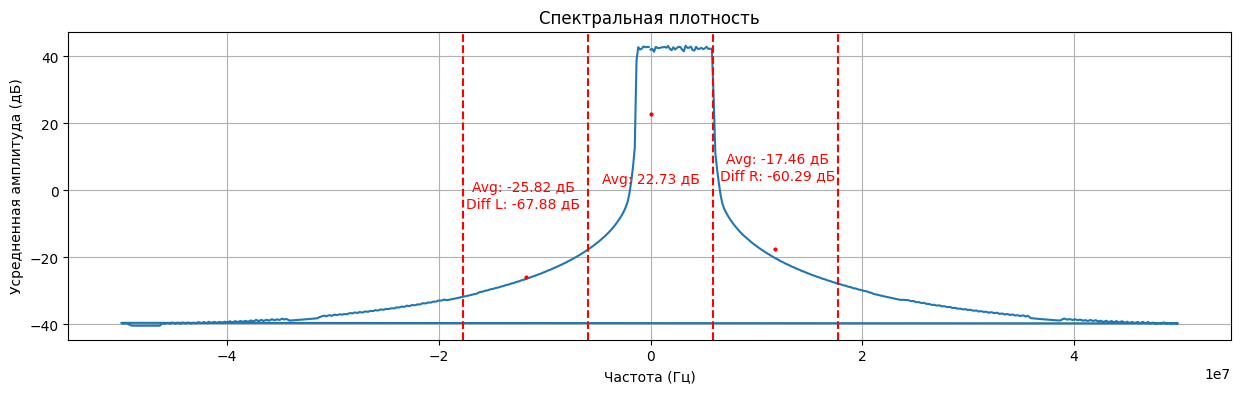

In [641]:
plot_spectrum(target_spectrum)

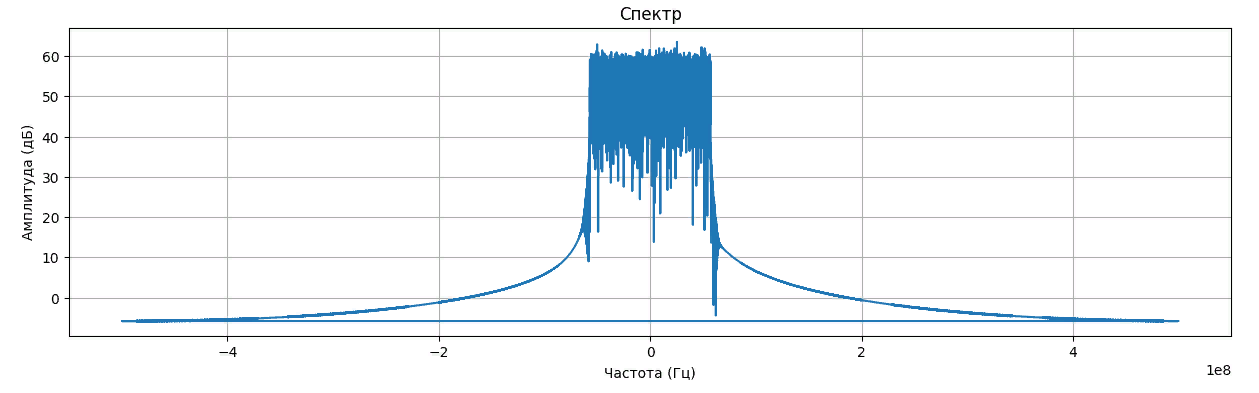

In [642]:
# def mean_squared_error(y_true, y_pred, sample_weight=None):
#     squared_diff = (y_true - y_pred) ** 2
#     # print("squared_diff: ", squared_diff)
#     # print("sample_weight: ", sample_weight[:, 4])

#     if sample_weight is not None:
#         weighted_squared_diff = squared_diff * sample_weight[:, 4]
#     else:
#         weighted_squared_diff = squared_diff

#     mse = torch.mean(weighted_squared_diff)
#     return mse


In [677]:
def mean_squared_error(y_true, y_pred, sample_weight=None):
    squared_diff = (y_true - y_pred) ** 2
    # print("y_true: ", y_true)
    # print("y_pred: ", y_pred)
    # print("squared_diff: ", squared_diff)
    # print("sample_weight: ", sample_weight[:, 4])

    # for value in y_true[:, 0]:
    #     if value > 1.7:
    #         print("y_true: ", y_true)
    #         print("y_pred: ", y_pred)
    #         print("sample_weight: ", sample_weight[:, 4])
    #         break



    if sample_weight is not None:
        weighted_squared_diff = squared_diff * sample_weight[:, 4]
    else:
        weighted_squared_diff = squared_diff

    mse = weighted_squared_diff
    return torch.mean(mse)


In [695]:
def logcosh(y_true, y_pred, sample_weight=None):
    squared_diff = torch.log(torch.cosh(y_true - y_pred))
    # print("y_true: ", y_true)
    # print("y_pred: ", y_pred)
    # print("squared_diff: ", squared_diff)
    # print("sample_weight: ", sample_weight[:, 4])

    # for value in y_true[:, 0]:
    #     if value > 1.7:
    #         print("y_true: ", y_true)
    #         print("y_pred: ", y_pred)
    #         print("sample_weight: ", sample_weight[:, 4])
    #         break



    if sample_weight is not None:
        weighted_squared_diff = squared_diff * sample_weight[:, 4]
    else:
        weighted_squared_diff = squared_diff

    mse = weighted_squared_diff
    return torch.mean(mse)

In [696]:
def mean_absolute_error(y_true, y_pred, sample_weight=None):
    abs_diff = torch.abs(y_true - y_pred)

    if sample_weight is not None:
        weighted_abs_diff = abs_diff * sample_weight
    else:
        weighted_abs_diff = abs_diff

    mae = torch.mean(weighted_abs_diff)
    return mae

In [697]:
# крутая
def huber_loss(y_true, y_pred, delta=1.0, sample_weight=None):
    diff = torch.abs(y_true - y_pred)
    loss = torch.where(diff < delta, 0.5 * diff**2, delta * diff - 0.5 * delta**2)

    if sample_weight is not None:
        loss = loss * sample_weight

    return torch.mean(loss)

In [698]:
def log_cosh_loss(y_true, y_pred, sample_weight=None):
    diff = y_pred - y_true
    loss = torch.log(torch.cosh(diff))

    if sample_weight is not None:
        loss = loss * sample_weight

    return torch.mean(loss)

In [699]:
# крутая самая
def smooth_l1_loss(y_true, y_pred, beta=1.0, sample_weight=None):
    diff = torch.abs(y_true - y_pred)
    loss = torch.where(diff < beta, 0.5 * diff**2 / beta, diff - 0.5 * beta)

    if sample_weight is not None:
        loss = loss * sample_weight

    return torch.mean(loss)

In [700]:
def l2_norms(y_true, y_pred, sample_weight=None):
    diff = y_true - y_pred
    squared_diff = diff ** 2

    if sample_weight is not None:
        weighted_squared_diff = squared_diff * sample_weight
    else:
        weighted_squared_diff = squared_diff

    # Calculate L2 norms for each example
    l2_norms = torch.sqrt(torch.sum(weighted_squared_diff, dim=1))

    # Take the logarithm of the sum of L2 norms
    loss = torch.log(torch.sum(l2_norms))

    return loss

In [701]:
def smooth_l1_loss_with_norm(y_true, y_pred, beta=1.0, l2_weight=0.1, sample_weight=None):
    diff = torch.abs(y_true - y_pred)
    loss = torch.where(diff < beta, 0.5 * diff**2 / beta, diff - 0.5 * beta)

    if sample_weight is not None:
        loss = loss * sample_weight

    l2_norm = torch.sqrt(torch.sum((y_true - y_pred)**2, dim=1))
    loss = torch.mean(loss) + l2_weight * torch.mean(l2_norm)  # Adding L2 norm term

    return torch.log(loss)  # Taking the logarithm of the loss

In [702]:
predict_spectrum = []

In [703]:
def composite_loss(y_target, y_pred, y_input, y__LINE_points, sample_weight, spectrum_switch):
    print('y_target: ', y_target, type(y_target), len(y_target))
    print('y_pred: ', y_pred, type(y_pred), len(y_pred))
    # print('y_input: ', y_input, type(y_input))

    global predict_spectrum
    predict_spectrum.clear()

    # mse_loss = nn.MSELoss()(y_target, y_pred)



    # mse_loss в случае sample_weight
    # mse_loss = mean_squared_error(y_target, y_pred, sample_weight[:, 4])

    # mse_loss в случае sample_weight
    mse_loss = smooth_l1_loss_with_norm(y_target, y_pred, sample_weight[:, 4])



    # выделяем реальную и мнимую части у предсказанных данных
    y_pred_list_0 = y_pred[:, 0]
    y_pred_list_1 = y_pred[:, 1]
    # print("y_pred_list_0: ", y_pred_list_0 ,len(y_pred_list_0), type(y_pred_list_0))
    # print("y_pred_list_1: ", y_pred_list_1 ,len(y_pred_list_1))


    # Определим что будет использовано для построения спектра
    if spectrum_switch == True:
        y_predict_complex = y_pred_list_0 + 1j * y_pred_list_1

        # Находим фазу комплексных чисел
        phases_predict = torch.angle(y_predict_complex)

        amplitude_predict = torch.abs(y_predict_complex)

        y__LINE_points = y__LINE_points[:, 4].squeeze()
        # print('y__LINE_points: ', y__LINE_points, y__LINE_points.shape, len(y__LINE_points))

        predict_ampl_after_NN = amplitude_predict - y__LINE_points

        I = predict_ampl_after_NN * torch.cos(phases_predict)
        Q = predict_ampl_after_NN * torch.sin(phases_predict)

        output_predict = I + 1j * Q

    else:
        I = y_pred_list_0
        Q = y_pred_list_1

        output_predict = I + 1j * Q
    # print("I: ", I)
    # print("Q: ", Q)





    # Рассчитываем масштабный коэффициент для аппроксимации
    scale_factor = output_predict.size(0) / y_pred_list_0.size(0)

    interp_pred_real = torch.nn.functional.interpolate(I.unsqueeze(0).unsqueeze(0), scale_factor=scale_factor, mode='linear').squeeze()
    interp_pred_imag = torch.nn.functional.interpolate(Q.unsqueeze(0).unsqueeze(0), scale_factor=scale_factor, mode='linear').squeeze()

    # Объединяем результаты обратно в комплексные числа
    interp_output_predict = interp_pred_real + 1j * interp_pred_imag
    predict_spectrum.append(output_predict)


    # print("target_spectrum: ", len(target_spectrum))
    # print("predict_spectrum: ", len(predict_spectrum[0].detach()))

    # Дополнительная часть потерь на основе расчета спектра (Если spectrum_switch=1)
    spectrum_loss = torch.mean(torch.abs(interp_output_predict))
    # spectrum_loss = torch.log(torch.sum(torch.abs(target_spectrum - predict_spectrum[0].detach())))


    # sample_weight = sample_weight[:, 4].ravel()
    # print("sample_weight: ", sample_weight, sample_weight.shape, len(sample_weight))

    # Общая функция потерь
    total_loss = mse_loss + 0.5*spectrum_loss/60
    # total_loss = mse_loss + 1.5*spectrum_loss/60


    print("mse_loss: ", mse_loss)
    print("spectrum_loss: ", 0.5*spectrum_loss/60)

    return total_loss

# Архитектура модели и цикл обучения

In [704]:
def custom_activation(x):
    return (torch.sigmoid(x) * 5.25) - 2.625

In [705]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn=custom_activation):
        super(LSTMPredictor, self).__init__()

        self.activation_fn = activation_fn

        # LSTM слой
        self.lstm_layer = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        # Линейный (полносвязный) выходной слой
        self.linear_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        # print("TYPE", type(x))
        # Преобразуем списки в тензоры PyTorch
        x_tensor = torch.tensor(x, dtype=torch.float32)

        # Пропуск входных данных через LSTM слой
        lstm_output, _ = self.lstm_layer(x_tensor)

        # Удаляем избыточные размерности
        lstm_output = lstm_output.squeeze()

        # Применяем кастомную функцию активации
        lstm_output = self.activation_fn(lstm_output)

        # Получение выхода из линейного слоя
        output = self.linear_layer(lstm_output)

        output = self.activation_fn(output[:, 4])

        return output


In [712]:
def train(model, tr_dataloader, val_dataloader, optimizer, criterion, num_epochs):
    # Определяем шедулер
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.05)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0

        for inputs, targets, y__LINE_points, sample_weight in tr_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)

            print("inputs: ", inputs)
            print("targets: ", targets)
            print("outputs: ", outputs)

            # loss = criterion(targets, outputs, inputs, y__LINE_points, sample_weight, spectrum_switch)
            loss = criterion(targets, outputs, sample_weight)# * sample_weight[:, 4])
            loss.backward()

            # посмотрим на градиенты:
            # gradients = outputs.clone().detach().requires_grad_(True)
            # print('gradients: ', gradients)

            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(tr_dataloader.dataset)

        # if epoch != 0:
        #     print("predict_spectrum[0].detach(): ", (predict_spectrum[0].detach()).shape)
        #     spectrum = calculate_spectrum(predict_spectrum[0].detach())
        #     plot_spectrum(spectrum)


        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                outputs = model(inputs)
                loss = criterion(targets, outputs, sample_weight)
                val_loss += loss.item() * inputs.size(0)
            val_loss /= len(val_dataloader.dataset)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.8f} - Val Loss: {val_loss:.8f}')
        # print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.8f}')
    scheduler.step()

In [713]:
# Задаем параметры
input_size = 2
hidden_size = 5
output_size = 2

learning_rate = 0.001
num_epochs = 40

spectrum_switch = 1

In [714]:
# Создаем модель
model = LSTMPredictor(input_size, hidden_size, output_size)

In [715]:
# Определяем функцию потерь и оптимизатор
criterion = logcosh
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Вызов функции обучения
# train(model, tr_trains, tr_targets, val_trains, val_targets, optimizer, criterion, num_epochs)
train(model, tr_dataloader, val_dataloader, optimizer, criterion, num_epochs)

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-705-e313e1add3ea>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)


Выходные данные были обрезаны до нескольких последних строк (5000).
        [[-3.0187e-01, -1.0819e-01],
         [-4.2168e-01, -9.4477e-02],
         [-4.9286e-01, -4.1189e-02],
         [-5.1860e-01,  4.1395e-02],
         [-5.0556e-01,  1.3971e-01]],

        [[-4.2168e-01, -9.4477e-02],
         [-4.9286e-01, -4.1189e-02],
         [-5.1860e-01,  4.1395e-02],
         [-5.0556e-01,  1.3971e-01],
         [-4.6287e-01,  2.3855e-01]],

        [[-4.9286e-01, -4.1189e-02],
         [-5.1860e-01,  4.1395e-02],
         [-5.0556e-01,  1.3971e-01],
         [-4.6287e-01,  2.3855e-01],
         [-4.0089e-01,  3.2296e-01]],

        [[-5.1860e-01,  4.1395e-02],
         [-5.0556e-01,  1.3971e-01],
         [-4.6287e-01,  2.3855e-01],
         [-4.0089e-01,  3.2296e-01],
         [-3.2989e-01,  3.8000e-01]],

        [[-5.0556e-01,  1.3971e-01],
         [-4.6287e-01,  2.3855e-01],
         [-4.0089e-01,  3.2296e-01],
         [-3.2989e-01,  3.8000e-01],
         [-2.5918e-01,  4.0032e-01]]

  2%|▎         | 1/40 [00:19<12:38, 19.44s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
         [ 0.8146, -0.0112]],

        [[ 0.7465,  0.3747],
         [ 0.8286,  0.2574],
         [ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461]],

        [[ 0.8286,  0.2574],
         [ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461],
         [ 0.5937, -0.2699]],

        [[ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461],
         [ 0.5937, -0.2699],
         [ 0.4338, -0.3751]],

        [[ 0.8146, -0.0112],
         [ 0.7254, -0.1461],
         [ 0.5937, -0.2699],
         [ 0.4338, -0.3751],
         [ 0.2622, -0.4563]],

        [[ 0.7254, -0.1461],
         [ 0.5937, -0.2699],
         [ 0.4338, -0.3751],
         [ 0.2622, -0.4563],
         [ 0.0960, -0.5100]],

        [[ 0.5937, -0.2699],
         [ 0.4338, -0.3751],
         [ 0.2622, -0.4563],
         [ 0.0960, -0.5100],
         [-0.0482, -0.5360]],

        [[ 0.4338, 

  5%|▌         | 2/40 [00:39<12:22, 19.54s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [[-0.5489,  0.2435],
         [-0.5210,  0.5448],
         [-0.4452,  0.8376],
         [-0.3306,  1.1050],
         [-0.1892,  1.3314]],

        [[-0.5210,  0.5448],
         [-0.4452,  0.8376],
         [-0.3306,  1.1050],
         [-0.1892,  1.3314],
         [-0.0356,  1.5035]],

        [[-0.4452,  0.8376],
         [-0.3306,  1.1050],
         [-0.1892,  1.3314],
         [-0.0356,  1.5035],
         [ 0.1156,  1.6118]],

        [[-0.3306,  1.1050],
         [-0.1892,  1.3314],
         [-0.0356,  1.5035],
         [ 0.1156,  1.6118],
         [ 0.2502,  1.6507]],

        [[-0.1892,  1.3314],
         [-0.0356,  1.5035],
         [ 0.1156,  1.6118],
         [ 0.2502,  1.6507],
         [ 0.3564,  1.6197]],

        [[-0.0356,  1.5035],
         [ 0.1156,  1.6118],
         [ 0.2502,  1.6507],
         [ 0.3564,  1.6197],
         [ 0.4258,  1.5222]],

        [[ 0.1156,  1.6118],
         [ 0.2502,  1

  8%|▊         | 3/40 [00:57<11:47, 19.13s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
         [ 0.4261,  0.5438]],

        [[-0.2558,  0.6093],
         [-0.0231,  0.6105],
         [ 0.2099,  0.5898],
         [ 0.4261,  0.5438],
         [ 0.6093,  0.4716]],

        [[-0.0231,  0.6105],
         [ 0.2099,  0.5898],
         [ 0.4261,  0.5438],
         [ 0.6093,  0.4716],
         [ 0.7465,  0.3747]],

        [[ 0.2099,  0.5898],
         [ 0.4261,  0.5438],
         [ 0.6093,  0.4716],
         [ 0.7465,  0.3747],
         [ 0.8286,  0.2574]],

        [[ 0.4261,  0.5438],
         [ 0.6093,  0.4716],
         [ 0.7465,  0.3747],
         [ 0.8286,  0.2574],
         [ 0.8510,  0.1262]],

        [[ 0.6093,  0.4716],
         [ 0.7465,  0.3747],
         [ 0.8286,  0.2574],
         [ 0.8510,  0.1262],
         [ 0.8146, -0.0112]],

        [[ 0.7465,  0.3747],
         [ 0.8286,  0.2574],
         [ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461]],

        [[ 0.8286, 

 10%|█         | 4/40 [01:17<11:41, 19.49s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [[-0.7660, -0.1204],
         [-0.7521, -0.0664],
         [-0.7103,  0.0041],
         [-0.6388,  0.0943],
         [-0.5390,  0.2051]],

        [[-0.7521, -0.0664],
         [-0.7103,  0.0041],
         [-0.6388,  0.0943],
         [-0.5390,  0.2051],
         [-0.4156,  0.3355]],

        [[-0.7103,  0.0041],
         [-0.6388,  0.0943],
         [-0.5390,  0.2051],
         [-0.4156,  0.3355],
         [-0.2771,  0.4817]],

        [[-0.6388,  0.0943],
         [-0.5390,  0.2051],
         [-0.4156,  0.3355],
         [-0.2771,  0.4817],
         [-0.1349,  0.6379]],

        [[-0.5390,  0.2051],
         [-0.4156,  0.3355],
         [-0.2771,  0.4817],
         [-0.1349,  0.6379],
         [-0.0020,  0.7963]],

        [[-0.4156,  0.3355],
         [-0.2771,  0.4817],
         [-0.1349,  0.6379],
         [-0.0020,  0.7963],
         [ 0.1079,  0.9482]],

        [[-0.2771,  0.4817],
         [-0.1349,  0

 12%|█▎        | 5/40 [01:36<11:13, 19.25s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
         [ 0.4866, -0.0754],
         [ 0.5426, -0.0345],
         [ 0.5641, -0.0018]],

        [[ 0.4001, -0.1208],
         [ 0.4866, -0.0754],
         [ 0.5426, -0.0345],
         [ 0.5641, -0.0018],
         [ 0.5502,  0.0204]],

        [[ 0.4866, -0.0754],
         [ 0.5426, -0.0345],
         [ 0.5641, -0.0018],
         [ 0.5502,  0.0204],
         [ 0.5030,  0.0317]],

        [[ 0.5426, -0.0345],
         [ 0.5641, -0.0018],
         [ 0.5502,  0.0204],
         [ 0.5030,  0.0317],
         [ 0.4266,  0.0326]],

        [[ 0.5641, -0.0018],
         [ 0.5502,  0.0204],
         [ 0.5030,  0.0317],
         [ 0.4266,  0.0326],
         [ 0.3269,  0.0249]],

        [[ 0.5502,  0.0204],
         [ 0.5030,  0.0317],
         [ 0.4266,  0.0326],
         [ 0.3269,  0.0249],
         [ 0.2110,  0.0112]],

        [[ 0.5030,  0.0317],
         [ 0.4266,  0.0326],
         [ 0.3269,  0.0249],
         [ 0.2110,  0

 15%|█▌        | 6/40 [01:56<11:02, 19.49s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
         [ 0.8146, -0.0112]],

        [[ 0.7465,  0.3747],
         [ 0.8286,  0.2574],
         [ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461]],

        [[ 0.8286,  0.2574],
         [ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461],
         [ 0.5937, -0.2699]],

        [[ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461],
         [ 0.5937, -0.2699],
         [ 0.4338, -0.3751]],

        [[ 0.8146, -0.0112],
         [ 0.7254, -0.1461],
         [ 0.5937, -0.2699],
         [ 0.4338, -0.3751],
         [ 0.2622, -0.4563]],

        [[ 0.7254, -0.1461],
         [ 0.5937, -0.2699],
         [ 0.4338, -0.3751],
         [ 0.2622, -0.4563],
         [ 0.0960, -0.5100]],

        [[ 0.5937, -0.2699],
         [ 0.4338, -0.3751],
         [ 0.2622, -0.4563],
         [ 0.0960, -0.5100],
         [-0.0482, -0.5360]],

        [[ 0.4338, 

 18%|█▊        | 7/40 [02:16<10:45, 19.56s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [[-0.7637, -0.4096],
         [-0.7094, -0.4348],
         [-0.6156, -0.4196],
         [-0.4879, -0.3644],
         [-0.3341, -0.2729]],

        [[-0.7094, -0.4348],
         [-0.6156, -0.4196],
         [-0.4879, -0.3644],
         [-0.3341, -0.2729],
         [-0.1647, -0.1520]],

        [[-0.6156, -0.4196],
         [-0.4879, -0.3644],
         [-0.3341, -0.2729],
         [-0.1647, -0.1520],
         [ 0.0088, -0.0107]],

        [[-0.4879, -0.3644],
         [-0.3341, -0.2729],
         [-0.1647, -0.1520],
         [ 0.0088, -0.0107],
         [ 0.1738,  0.1407]],

        [[-0.3341, -0.2729],
         [-0.1647, -0.1520],
         [ 0.0088, -0.0107],
         [ 0.1738,  0.1407],
         [ 0.3180,  0.2912]],

        [[-0.1647, -0.1520],
         [ 0.0088, -0.0107],
         [ 0.1738,  0.1407],
         [ 0.3180,  0.2912],
         [ 0.4303,  0.4305]],

        [[ 0.0088, -0.0107],
         [ 0.1738,  0

 20%|██        | 8/40 [02:36<10:30, 19.71s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
         [-0.6388,  0.0943]],

        [[-0.7660, -0.1204],
         [-0.7521, -0.0664],
         [-0.7103,  0.0041],
         [-0.6388,  0.0943],
         [-0.5390,  0.2051]],

        [[-0.7521, -0.0664],
         [-0.7103,  0.0041],
         [-0.6388,  0.0943],
         [-0.5390,  0.2051],
         [-0.4156,  0.3355]],

        [[-0.7103,  0.0041],
         [-0.6388,  0.0943],
         [-0.5390,  0.2051],
         [-0.4156,  0.3355],
         [-0.2771,  0.4817]],

        [[-0.6388,  0.0943],
         [-0.5390,  0.2051],
         [-0.4156,  0.3355],
         [-0.2771,  0.4817],
         [-0.1349,  0.6379]],

        [[-0.5390,  0.2051],
         [-0.4156,  0.3355],
         [-0.2771,  0.4817],
         [-0.1349,  0.6379],
         [-0.0020,  0.7963]],

        [[-0.4156,  0.3355],
         [-0.2771,  0.4817],
         [-0.1349,  0.6379],
         [-0.0020,  0.7963],
         [ 0.1079,  0.9482]],

        [[-0.2771, 

 22%|██▎       | 9/40 [02:55<10:08, 19.61s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [[ 0.7465,  0.3747],
         [ 0.8286,  0.2574],
         [ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461]],

        [[ 0.8286,  0.2574],
         [ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461],
         [ 0.5937, -0.2699]],

        [[ 0.8510,  0.1262],
         [ 0.8146, -0.0112],
         [ 0.7254, -0.1461],
         [ 0.5937, -0.2699],
         [ 0.4338, -0.3751]],

        [[ 0.8146, -0.0112],
         [ 0.7254, -0.1461],
         [ 0.5937, -0.2699],
         [ 0.4338, -0.3751],
         [ 0.2622, -0.4563]],

        [[ 0.7254, -0.1461],
         [ 0.5937, -0.2699],
         [ 0.4338, -0.3751],
         [ 0.2622, -0.4563],
         [ 0.0960, -0.5100]],

        [[ 0.5937, -0.2699],
         [ 0.4338, -0.3751],
         [ 0.2622, -0.4563],
         [ 0.0960, -0.5100],
         [-0.0482, -0.5360]],

        [[ 0.4338, -0.3751],
         [ 0.2622, -0

 25%|██▌       | 10/40 [03:17<10:07, 20.25s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
         [-5.1860e-01,  4.1395e-02]],

        [[-3.0187e-01, -1.0819e-01],
         [-4.2168e-01, -9.4477e-02],
         [-4.9286e-01, -4.1189e-02],
         [-5.1860e-01,  4.1395e-02],
         [-5.0556e-01,  1.3971e-01]],

        [[-4.2168e-01, -9.4477e-02],
         [-4.9286e-01, -4.1189e-02],
         [-5.1860e-01,  4.1395e-02],
         [-5.0556e-01,  1.3971e-01],
         [-4.6287e-01,  2.3855e-01]],

        [[-4.9286e-01, -4.1189e-02],
         [-5.1860e-01,  4.1395e-02],
         [-5.0556e-01,  1.3971e-01],
         [-4.6287e-01,  2.3855e-01],
         [-4.0089e-01,  3.2296e-01]],

        [[-5.1860e-01,  4.1395e-02],
         [-5.0556e-01,  1.3971e-01],
         [-4.6287e-01,  2.3855e-01],
         [-4.0089e-01,  3.2296e-01],
         [-3.2989e-01,  3.8000e-01]],

        [[-5.0556e-01,  1.3971e-01],
         [-4.6287e-01,  2.3855e-01],
         [-4.0089e-01,  3.2296e-01],
         [-3.2989e-01,  3.8000e-01

 28%|██▊       | 11/40 [03:37<09:45, 20.19s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [[ 0.2194,  0.0330],
         [ 0.1777,  0.0555],
         [ 0.1122,  0.0539],
         [ 0.0248,  0.0233],
         [-0.0799, -0.0370]],

        [[ 0.1777,  0.0555],
         [ 0.1122,  0.0539],
         [ 0.0248,  0.0233],
         [-0.0799, -0.0370],
         [-0.1943, -0.1238]],

        [[ 0.1122,  0.0539],
         [ 0.0248,  0.0233],
         [-0.0799, -0.0370],
         [-0.1943, -0.1238],
         [-0.3084, -0.2298]],

        [[ 0.0248,  0.0233],
         [-0.0799, -0.0370],
         [-0.1943, -0.1238],
         [-0.3084, -0.2298],
         [-0.4107, -0.3444]],

        [[-0.0799, -0.0370],
         [-0.1943, -0.1238],
         [-0.3084, -0.2298],
         [-0.4107, -0.3444],
         [-0.4889, -0.4548]],

        [[-0.1943, -0.1238],
         [-0.3084, -0.2298],
         [-0.4107, -0.3444],
         [-0.4889, -0.4548],
         [-0.5313, -0.5473]],

        [[-0.3084, -0.2298],
         [-0.4107, -0

 30%|███       | 12/40 [03:58<09:34, 20.53s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
         [ 0.4056, -0.2248],
         [ 0.4336, -0.1293],
         [ 0.4437, -0.0503]],

        [[ 0.3627, -0.3329],
         [ 0.4056, -0.2248],
         [ 0.4336, -0.1293],
         [ 0.4437, -0.0503],
         [ 0.4346,  0.0092]],

        [[ 0.4056, -0.2248],
         [ 0.4336, -0.1293],
         [ 0.4437, -0.0503],
         [ 0.4346,  0.0092],
         [ 0.4060,  0.0474]],

        [[ 0.4336, -0.1293],
         [ 0.4437, -0.0503],
         [ 0.4346,  0.0092],
         [ 0.4060,  0.0474],
         [ 0.3588,  0.0638]],

        [[ 0.4437, -0.0503],
         [ 0.4346,  0.0092],
         [ 0.4060,  0.0474],
         [ 0.3588,  0.0638],
         [ 0.2955,  0.0585]],

        [[ 0.4346,  0.0092],
         [ 0.4060,  0.0474],
         [ 0.3588,  0.0638],
         [ 0.2955,  0.0585],
         [ 0.2194,  0.0325]],

        [[ 0.4060,  0.0474],
         [ 0.3588,  0.0638],
         [ 0.2955,  0.0585],
         [ 0.2194,  0

 32%|███▎      | 13/40 [04:18<09:09, 20.35s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
         [-0.6388,  0.0943]],

        [[-0.7660, -0.1204],
         [-0.7521, -0.0664],
         [-0.7103,  0.0041],
         [-0.6388,  0.0943],
         [-0.5390,  0.2051]],

        [[-0.7521, -0.0664],
         [-0.7103,  0.0041],
         [-0.6388,  0.0943],
         [-0.5390,  0.2051],
         [-0.4156,  0.3355]],

        [[-0.7103,  0.0041],
         [-0.6388,  0.0943],
         [-0.5390,  0.2051],
         [-0.4156,  0.3355],
         [-0.2771,  0.4817]],

        [[-0.6388,  0.0943],
         [-0.5390,  0.2051],
         [-0.4156,  0.3355],
         [-0.2771,  0.4817],
         [-0.1349,  0.6379]],

        [[-0.5390,  0.2051],
         [-0.4156,  0.3355],
         [-0.2771,  0.4817],
         [-0.1349,  0.6379],
         [-0.0020,  0.7963]],

        [[-0.4156,  0.3355],
         [-0.2771,  0.4817],
         [-0.1349,  0.6379],
         [-0.0020,  0.7963],
         [ 0.1079,  0.9482]],

        [[-0.2771, 

 35%|███▌      | 14/40 [04:39<08:55, 20.61s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
         [-0.6847, -0.4352]],

        [[-0.3705, -0.3293],
         [-0.5021, -0.3787],
         [-0.6098, -0.4137],
         [-0.6847, -0.4352],
         [-0.7205, -0.4445]],

        [[-0.5021, -0.3787],
         [-0.6098, -0.4137],
         [-0.6847, -0.4352],
         [-0.7205, -0.4445],
         [-0.7136, -0.4430]],

        [[-0.6098, -0.4137],
         [-0.6847, -0.4352],
         [-0.7205, -0.4445],
         [-0.7136, -0.4430],
         [-0.6640, -0.4325]],

        [[-0.6847, -0.4352],
         [-0.7205, -0.4445],
         [-0.7136, -0.4430],
         [-0.6640, -0.4325],
         [-0.5749, -0.4149]],

        [[-0.7205, -0.4445],
         [-0.7136, -0.4430],
         [-0.6640, -0.4325],
         [-0.5749, -0.4149],
         [-0.4530, -0.3926]],

        [[-0.7136, -0.4430],
         [-0.6640, -0.4325],
         [-0.5749, -0.4149],
         [-0.4530, -0.3926],
         [-0.3074, -0.3681]],

        [[-0.6640, 

 38%|███▊      | 15/40 [04:59<08:31, 20.47s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [[ 0.0714, -0.3948],
         [ 0.1529, -0.4705],
         [ 0.1777, -0.5412],
         [ 0.1486, -0.6015],
         [ 0.0726, -0.6453]],

        [[ 0.1529, -0.4705],
         [ 0.1777, -0.5412],
         [ 0.1486, -0.6015],
         [ 0.0726, -0.6453],
         [-0.0393, -0.6668]],

        [[ 0.1777, -0.5412],
         [ 0.1486, -0.6015],
         [ 0.0726, -0.6453],
         [-0.0393, -0.6668],
         [-0.1743, -0.6611]],

        [[ 0.1486, -0.6015],
         [ 0.0726, -0.6453],
         [-0.0393, -0.6668],
         [-0.1743, -0.6611],
         [-0.3180, -0.6250]],

        [[ 0.0726, -0.6453],
         [-0.0393, -0.6668],
         [-0.1743, -0.6611],
         [-0.3180, -0.6250],
         [-0.4571, -0.5580]],

        [[-0.0393, -0.6668],
         [-0.1743, -0.6611],
         [-0.3180, -0.6250],
         [-0.4571, -0.5580],
         [-0.5794, -0.4619]],

        [[-0.1743, -0.6611],
         [-0.3180, -0

 40%|████      | 16/40 [05:23<08:30, 21.28s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
        [[-0.9485, -1.3654],
         [-0.6383, -1.3305],
         [-0.2785, -1.2516],
         [ 0.0983, -1.1378],
         [ 0.4591, -1.0020]],

        [[-0.6383, -1.3305],
         [-0.2785, -1.2516],
         [ 0.0983, -1.1378],
         [ 0.4591, -1.0020],
         [ 0.7741, -0.8589]],

        [[-0.2785, -1.2516],
         [ 0.0983, -1.1378],
         [ 0.4591, -1.0020],
         [ 0.7741, -0.8589],
         [ 1.0194, -0.7237]],

        [[ 0.0983, -1.1378],
         [ 0.4591, -1.0020],
         [ 0.7741, -0.8589],
         [ 1.0194, -0.7237],
         [ 1.1791, -0.6102]],

        [[ 0.4591, -1.0020],
         [ 0.7741, -0.8589],
         [ 1.0194, -0.7237],
         [ 1.1791, -0.6102],
         [ 1.2468, -0.5292]],

        [[ 0.7741, -0.8589],
         [ 1.0194, -0.7237],
         [ 1.1791, -0.6102],
         [ 1.2468, -0.5292],
         [ 1.2253, -0.4873]],

        [[ 1.0194, -0.7237],
         [ 1.1791, -0

In [ ]:
model.save('LSTM_samplew_v1.h5')

Длина выходных данных STFT зависит от размерности входных данных, параметра n_fft (количество отсчетов в Быстром Преобразовании Фурье) и параметра hop_length (шаг перекрытия).

Пусть:

L_data - длина входных данных (количество отсчетов во временной области)
n_fft - количество отсчетов в Быстром Преобразовании Фурье
hop_length - шаг перекрытия между временными сегментами
Тогда длина выходных данных STFT (количество временных сегментов) может быть вычислена по следующей формуле: **num_segments = 1 + (L_data - n_fft) // hop_length**

MSE (300 Эпох, Шедулер 20эпох с шагом 0,05)

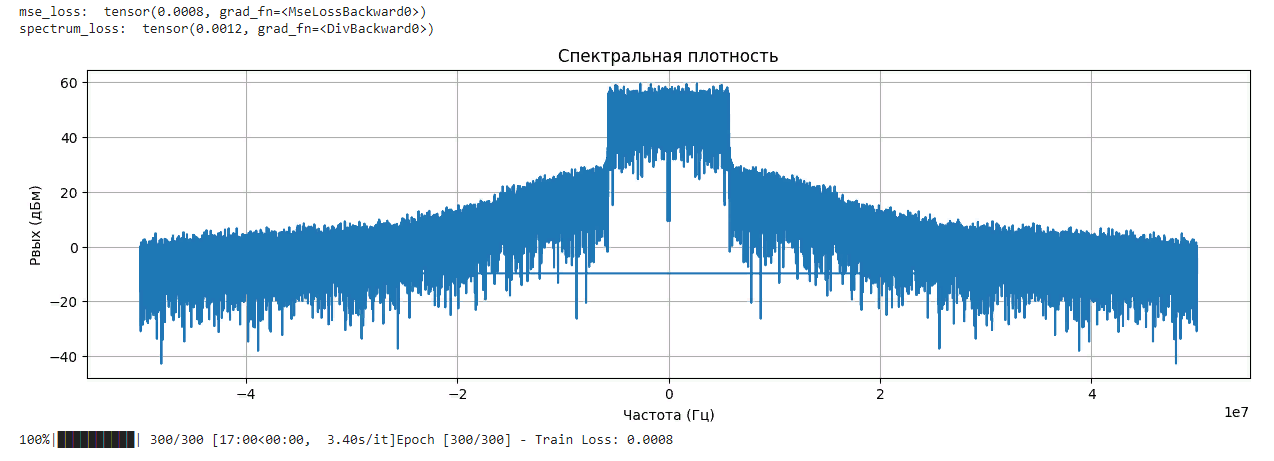

MSE + spectral_loss (300 Эпох, Шедулер 20эпох с шагом 0,05)

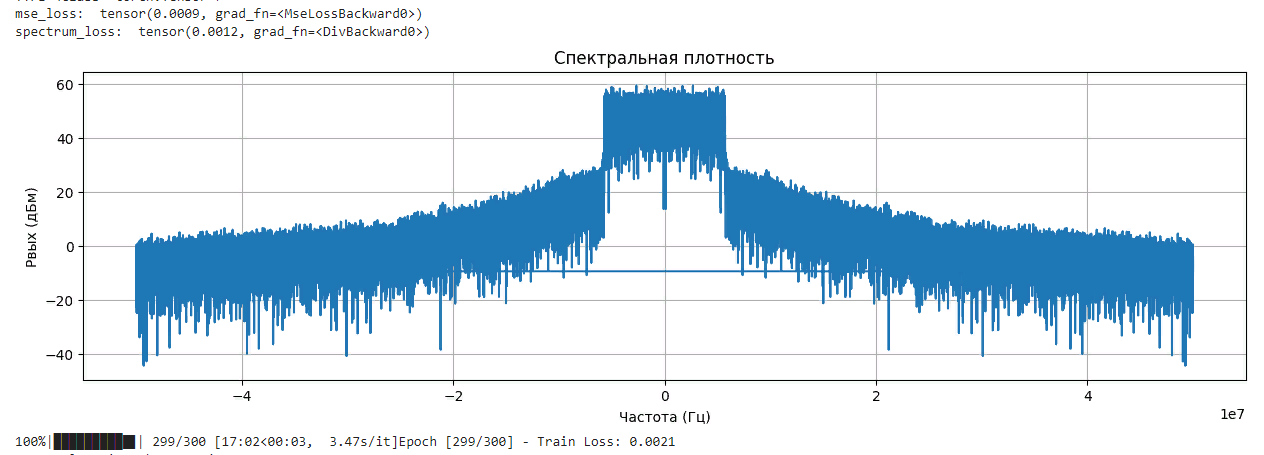

MSE (300 Эпох, Шедулер 20эпох с шагом 0,05)

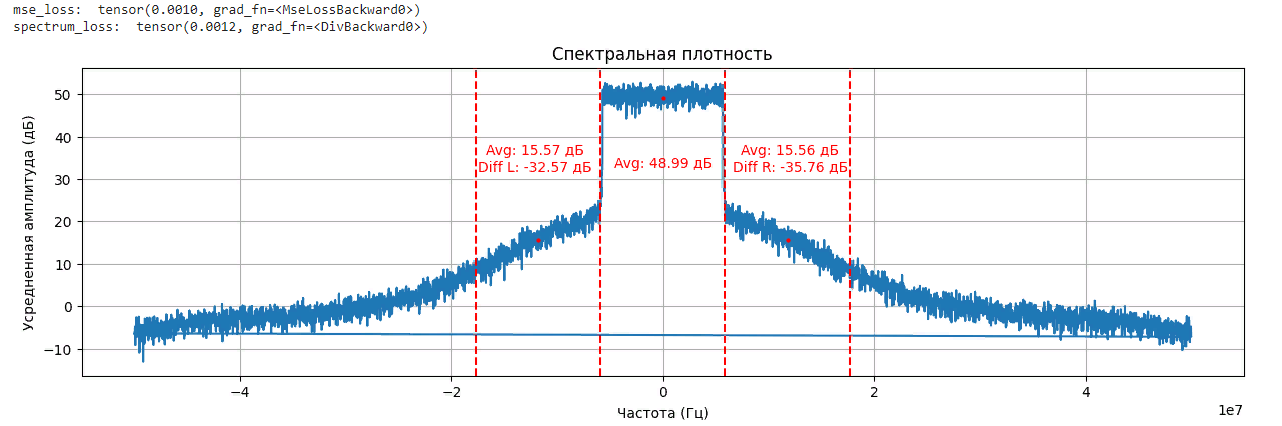

MSE + spectral_loss (300 Эпох, Шедулер 20эпох с шагом 0,05)

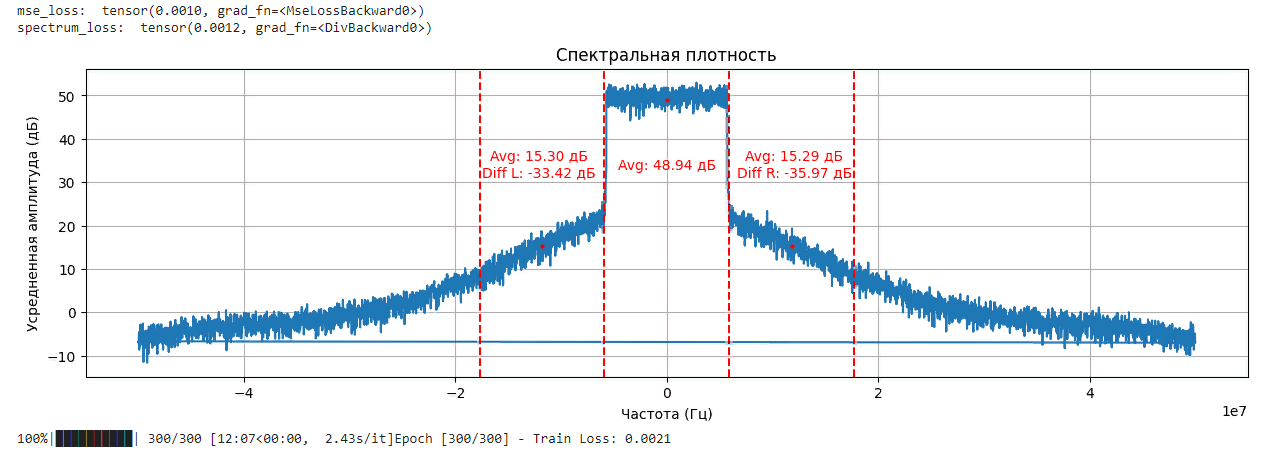

MSE + spectral_loss (300 Эпох, Шедулер 20эпох с шагом 0,05)   Увеличил коэффициент влияния spectr loss с 0,1 до 0,5

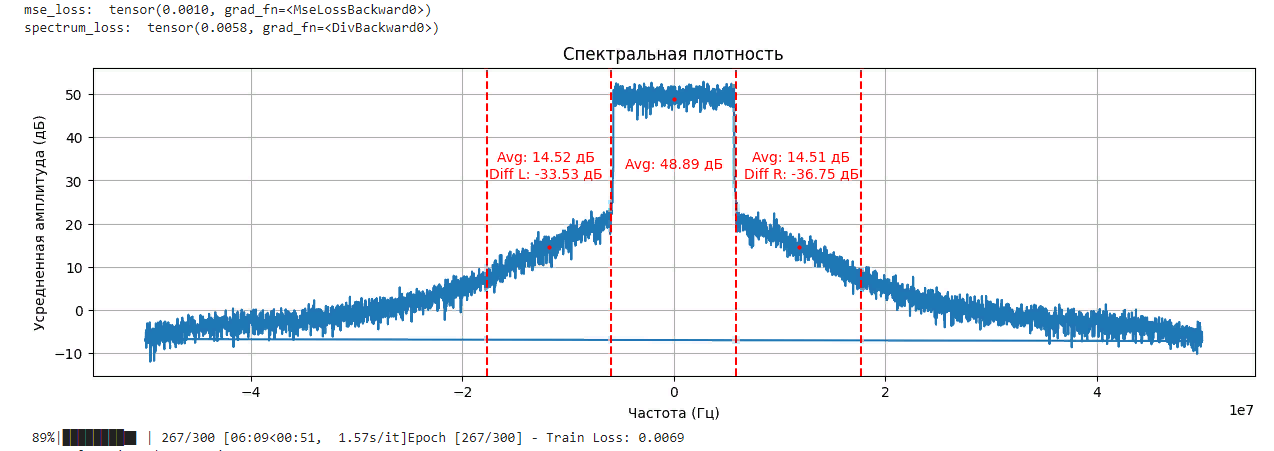

**Далее эксперименты с 600 эпохами**

MSE (600 Эпох, начальный lr=0,1  Шедулер 50эпох с шагом 0,05)  начальный lr в прошлых примерах тоже 0,1

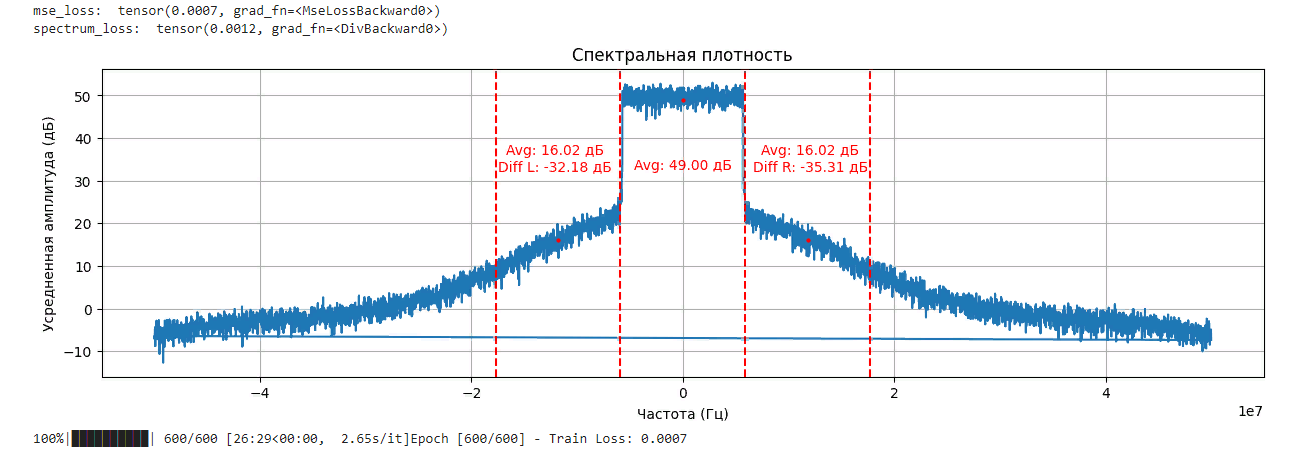

MSE + spectral_loss (600 Эпох, начальный lr=0,1 Шедулер 50эпох с шагом 0,05)

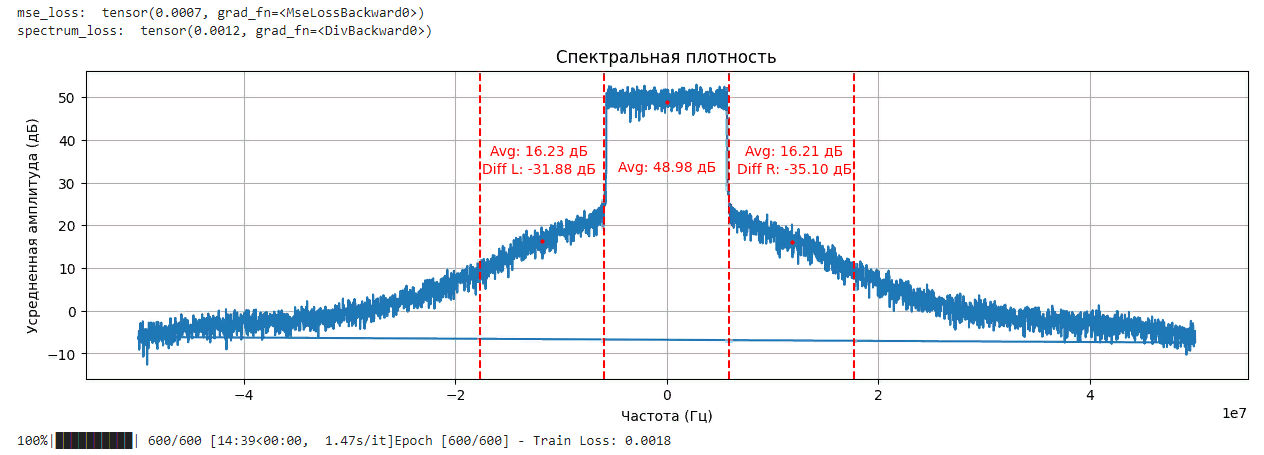

MSE + spectral_loss + sample_weight (total_loss = mse_loss + 0.5*spectrum_loss/60) (300 Эпох, начальный lr=0,1 Шедулер 20эпох с шагом 0,05)

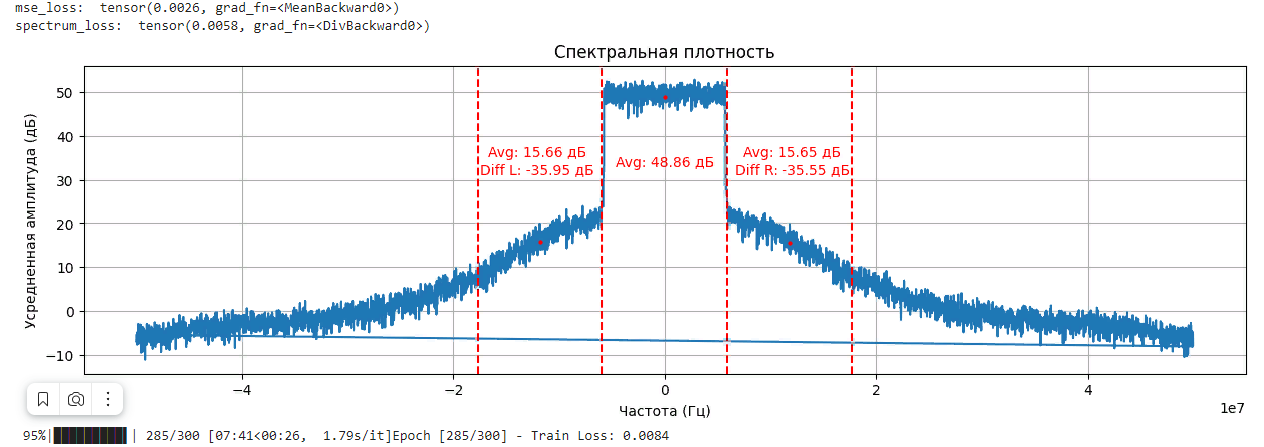

In [ ]:
import torch
import matplotlib.pyplot as plt

# Гиперпараметры
sample_rate = 44100
num_samples = 1000
n_fft = 2048
hop_length = 512

# Генерируем тестовый сигнал (комплексные значения)
signal = torch.randn(2, num_samples) + 1j * torch.randn(2, num_samples)

# Вычисляем STFT
specgram = torch.stft(signal, n_fft=n_fft, hop_length=hop_length, window=torch.hann_window(n_fft), return_complex=True)

# Извлекаем амплитуды и переводим в децибеллы
specgram_mag = torch.abs(specgram)
specgram_mag_db = 20 * torch.log10(specgram_mag + 1e-9)  # Добавляем маленькое значение для избежания логарифма от нуля

# Отображаем спектрограмму
plt.imshow(specgram_mag_db[0].T.numpy(), cmap='inferno', origin='lower', aspect='auto', extent=[0, num_samples, 0, n_fft // 2])
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time Steps')
plt.ylabel('Frequency Bins')
plt.show()


In [268]:
import h5py

# Сохранение модели в файл формата HDF5
model_path = 'my_model.h5'
with h5py.File(model_path, 'w') as hf:
    for name, param in model.named_parameters():
        hf.create_dataset(name, data=param.data.numpy())

In [ ]:
# Загрузка модели из файла формата HDF5
loaded_model = MyModel()
with h5py.File(model_path, 'r') as hf:
    for name, param in loaded_model.named_parameters():
        param.data[:] = hf[name][:]
loaded_model.eval()  # Установка режима оценки (evaluation mode)

In [661]:
# Загрузим массив входных в ИНС значений амплитуд
input_NN_amplitudes = 'input_NN_amplitudes.txt'
# input_NN_amplitudes = np.loadtxt(input_NN_amplitudes, delimiter='\n')
input_NN_amplitudes = np.loadtxt(input_NN_amplitudes, delimiter=None)

# Загрузим массив-учитель целевых выходных из ИНС значений амплитуд
goal_output_NN_amplitudes = 'goal_output_NN_amplitudes.txt'
# goal_output_NN_amplitudes = np.loadtxt(goal_output_NN_amplitudes, delimiter='\n')
goal_output_NN_amplitudes = np.loadtxt(goal_output_NN_amplitudes, delimiter=None)

In [662]:
# проверка для построения графиков
predicted = model(batch_trains)

In [663]:
# найдем выходную амплитуду из предсказанных Re и Im комплексных частей
re = predicted[:, 0]
# print(re)
im = predicted[:, 1]
# print(im)

amplitude_predict = (re ** 2 + im ** 2) ** 0.5

In [664]:
len(amplitude_predict)

48374

In [665]:
# укоротим входной массив данных. Это делается потому что предсказанных значений на выходе меньше на memory_size*2, чем
# значений амплитуд во входной выборке. И последовательность эта сдвинута на 1.
X = input_NN_amplitudes[(memory_size*2-1): length-1]

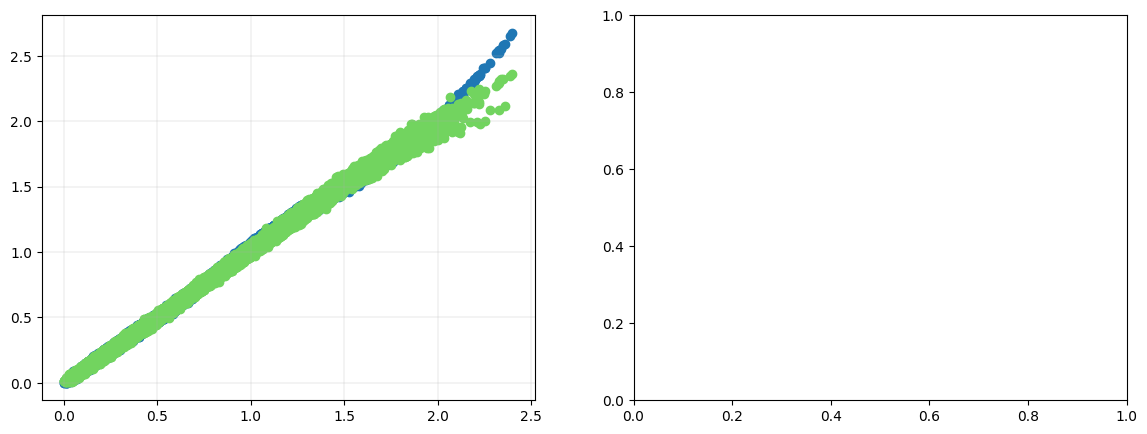

In [666]:
# построим график амплитуд
fig_1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax1.grid(linewidth=0.2)
ax1.scatter(input_NN_amplitudes, goal_output_NN_amplitudes)
ax1.scatter(X, amplitude_predict.detach().numpy(), c='#72D45F')

In [667]:
# ВНИМАНИЕ: Ниже показано то, как понастоящему согласовать точки, ибо у двух последовательностей они находятся на разных
# местах ибо при подаче на вход тензора задействуются сразу несколько входных данных, а на выходе имеется только одно
# значение предсказания (все из-за размерности входа LSTM !)
# a = 16397
a = 16390
ax1.scatter(input_NN_amplitudes[a], goal_output_NN_amplitudes[a], c='black')
ax1.scatter(X[a-(memory_size*2-1)], amplitude_predict[a-(memory_size*2-1)].detach().numpy(), c='red')
ax1.tick_params(axis='both', which='major', labelsize=12)

In [668]:

# подготовим данные для построения графиков амплитуд и фаз
Re_array_AM_AM_and_AM_PH_corrected = pd.read_csv('Re_array_AM_AM_and_AM_PH_corrected.csv',delimiter = ',', names = ['A'])
Re_array_inputPA = Re_array_AM_AM_and_AM_PH_corrected.to_numpy()

Im_array_AM_AM_and_AM_PH_corrected = pd.read_csv('Im_array_AM_AM_and_AM_PH_corrected.csv',delimiter = ',', names = ['A'])
Im_array_inputPA = Im_array_AM_AM_and_AM_PH_corrected.to_numpy()




RE_array_paInput = 'RE_array_paInput.txt'
RE_array_paInput = np.loadtxt(RE_array_paInput, delimiter=None)

IM_array_paInput = 'IM_array_paInput.txt'
IM_array_paInput = np.loadtxt(IM_array_paInput, delimiter=None)



predict_Re_1 = re
predict_Im_1 = im
# print('predict_Re_1', predict_Re_1.shape)



XX = (RE_array_paInput ** 2 + IM_array_paInput ** 2) ** 0.5
yy = (Re_array_inputPA ** 2 + Im_array_inputPA ** 2) ** 0.5
# print('XX', XX.shape)


In [669]:
# теперь построим графики фазы на входе и на выходе ИНС:
Fi_output_NN_celevoi_vertor_minus_Fi_input_NN = []
Fi_output_NN_minus_Fi_input_NN = []

Re_array_inputPA = Re_array_inputPA[(memory_size*2-1): length-1]
Im_array_inputPA = Im_array_inputPA[(memory_size*2-1): length-1]
RE_array_paInput = RE_array_paInput[(memory_size*2-1): length-1]
IM_array_paInput = IM_array_paInput[(memory_size*2-1): length-1]

for r in range(len(Im_array_inputPA)):
    if XX[r] > 0:
        V1 = math.atan2(Im_array_inputPA[r], Re_array_inputPA[r]) * 180 / math.pi
        V3 = math.atan2(IM_array_paInput[r], RE_array_paInput[r]) * 180 / math.pi
        V2 = math.atan2(predict_Im_1[r], predict_Re_1[r]) * 180 / math.pi


        # фаза выходная из УМ минус фаза входная в УМ
        M1 = V1 - V3
        M2 = V2 - V3

        if M1 > 180:
            M1 = M1 - 360
        elif M1 < -180:
            M1 = M1 + 360
        if 110 < M1 < 180:
            M1 = M1 - 180
        if -110 > M1 > -180:
            M1 = M1 + 180


        if M2 > 180:
            M2 = M2 - 360
        elif M2 < -180:
            M2 = M2 + 360

        Fi_output_NN_celevoi_vertor_minus_Fi_input_NN.append(M1)
        Fi_output_NN_minus_Fi_input_NN.append(M2)

Fi_output_NN_celevoi_vertor_minus_Fi_input_NN = np.array(Fi_output_NN_celevoi_vertor_minus_Fi_input_NN).reshape(-1, 1)
Fi_output_NN_minus_Fi_input_NN = np.array(Fi_output_NN_minus_Fi_input_NN)#.reshape(-1, 1)

XX 1.00003664820165


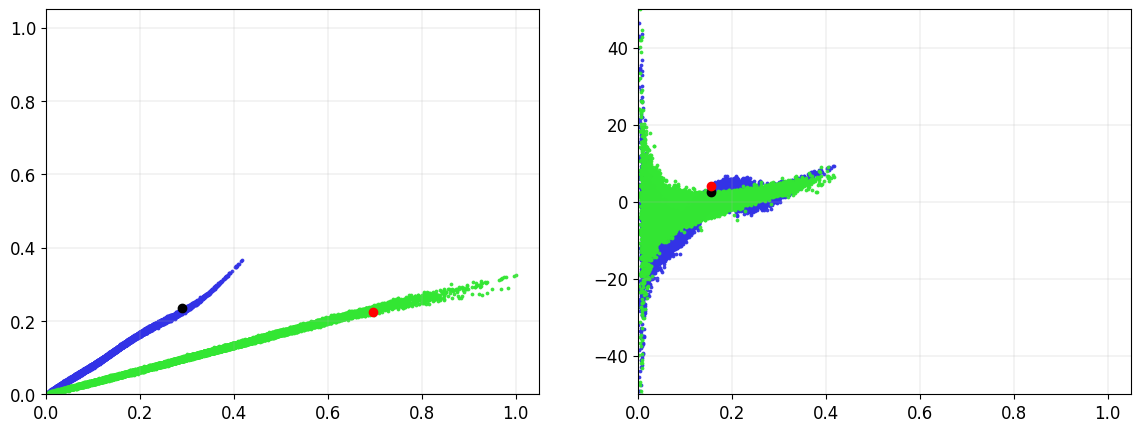

In [671]:
# построим графики амплитуды и фазы на выходе ИНС (т.е. насколько обучение совпадает с таргетом)
fig_2, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
# ax1.set_title('Home value as a function of home age & area population', fontsize=14)

xmin = 0
xmax = 1
ymin = 0
ymax = 1
# ax1.axis([xmin, xmax, ymin, ymax])

# print('input_NN_amplitudes', input_NN_amplitudes.max())
# print('goal_output_NN_amplitudes', goal_output_NN_amplitudes.max())
# print('X', X.max())
# print('amplitude_predict', amplitude_predict.max())

input_NN_amplitudes = input_NN_amplitudes/2.4
goal_output_NN_amplitudes = goal_output_NN_amplitudes/2.7
XXX = X/2.4
amplitude_predict = amplitude_predict/2.7
# ax1.scatter(XX, yy)

xmin = 0
xmax = 1.05
ymin = 0
ymax = 1.05
ax1.axis([xmin, xmax, ymin, ymax])

ax1.scatter(input_NN_amplitudes, goal_output_NN_amplitudes, c=[[0.2, 0.2, 0.9, 0.9]], s=3)
ax1.scatter(XXX, amplitude_predict.detach().numpy(), c=[[0.2, 0.9, 0.2, 0.9]], s=3)

# ВНИМАНИЕ: Ниже показано то, как понастоящему согласовать точки, ибо у двух последовательностей они находятся на разных
# местах ибо при подаче на вход тензора задействуются сразу несколько входных данных, а на выходе имеется только одно
# значение предсказания (все из-за размерности входа LSTM !)
# a = 16397
a = 16390
ax1.grid(linewidth=0.2)

ax1.scatter(input_NN_amplitudes[a], goal_output_NN_amplitudes[a], c='black')
ax1.scatter(XXX[a-(memory_size*2-1)], amplitude_predict[a-(memory_size*2-1)].detach().numpy(), c='red')
ax1.tick_params(axis='both', which='major', labelsize=12)

print('XX', XX.max())
XX = XX/2.4

xmin = 0
xmax = 1.05
ymin = -50
ymax = 50
ax2.axis([xmin, xmax, ymin, ymax])

ax2.grid(linewidth=0.2)
ax2.scatter(XX[(memory_size*2-1): length-1], Fi_output_NN_celevoi_vertor_minus_Fi_input_NN, c=[[0.2, 0.2, 0.9, 0.9]], s=3)
ax2.scatter(XX[(memory_size*2-1): length-1], Fi_output_NN_minus_Fi_input_NN, c=[[0.2, 0.9, 0.2, 0.9]], s=3)

# покажем точки
ax2.scatter(XX[a-(memory_size*2-1)], Fi_output_NN_minus_Fi_input_NN[a-(memory_size*2-1)], c='black')
ax2.scatter(XX[a-(memory_size*2-1)], Fi_output_NN_celevoi_vertor_minus_Fi_input_NN[a-(memory_size*2-1)], c='red')
ax2.tick_params(axis='both', which='major', labelsize=12)

In [618]:
# построение АМ-АМ и АМ-ФМ графиков на выходе усилителя мощности

# амплитуда:
RE_array_paOutput = 'RE_array_paOutput.txt'
RE_array_paOutput = np.loadtxt(RE_array_paOutput, delimiter=None)
# print(RE_array_paOutput)
# print(type(RE_array_paOutput))

IM_array_paOutput = 'IM_array_paOutput.txt'
IM_array_paOutput = np.loadtxt(IM_array_paOutput, delimiter=None)
# print(IM_array_paOutput)
# print(type(IM_array_paOutput))

y_output_INC = (RE_array_paOutput ** 2 + IM_array_paOutput ** 2) ** 0.5
y_output_INC = y_output_INC/22.8755

# y = (RE_array_paOutput ** 2 + IM_array_paOutput ** 2) ** 0.5
# y = np.reshape(y, (-2, 1))

predict_y = (re ** 2 + im ** 2) ** 0.5


# фаза:
Fi_output_PA_withoutDOD = pd.read_csv('Fi_output_minus_Fi_input.csv', delimiter = ',', names = ['A'])
Fi_output_PA_withoutDOD = np.array(Fi_output_PA_withoutDOD)
Fi_output_PA_withoutDOD = np.resize(Fi_output_PA_withoutDOD, (len(Fi_output_PA_withoutDOD), ))

Fi_output_PA_after_DPD = Fi_output_PA_withoutDOD[(memory_size*2-1): length-1] + Fi_output_NN_minus_Fi_input_NN

Fi_output = []

for r in range(len(Im_array_inputPA)):
    M3 = 0
    if Fi_output_PA_after_DPD[r] > 180:
        M3 = Fi_output_PA_after_DPD[r] - 360
    if Fi_output_PA_after_DPD[r] < -180:
        M3 = Fi_output_PA_after_DPD[r] + 360
    else: M3 = Fi_output_PA_after_DPD[r]

    Fi_output.append(M3)
Fi_output_PA_after_DPD = np.array(Fi_output)


FileNotFoundError: ignored

In [ ]:

T1 = []
T2 = []

for r in range(len(Im_array_inputPA)):
    if XX[r] > 0:
        V1 = math.atan2(Im_array_inputPA[r], Re_array_inputPA[r]) * 180 / math.pi
        V3 = math.atan2(IM_array_paInput[r], RE_array_paInput[r]) * 180 / math.pi
        V2 = math.atan2(predict_Im_1[r], predict_Re_1[r]) * 180 / math.pi


        # фаза выходная из УМ минус фаза входная в УМ
        M1 = V3 - V1
        M2 = V2 - V3

        if M1 > 180:
            M1 = M1 - 360
        elif M1 < -180:
            M1 = M1 + 360
        if 110 < M1 < 180:
            M1 = M1 - 180
        if -110 > M1 > -180:
            M1 = M1 + 180


        if M2 > 180:
            M2 = M2 - 360
        elif M2 < -180:
            M2 = M2 + 360

        T1.append(M1)
        T2.append(M2)

Vec1 = np.array(T1).reshape(-1, 1)
Vec2 = np.array(T2)#.reshape(-1, 1)













fig_3, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
# ax1.set_title('Home value as a function of home age & area population', fontsize=14)




xmin = 0
xmax = 1.05
ymin = 0
ymax = 1.05
ax1.axis([xmin, xmax, ymin, ymax])
ax1.tick_params(axis='both', which='major', labelsize=12)
# print('input_NN_amplitudes', input_NN_amplitudes.max())
# print('goal_output_NN_amplitudes', goal_output_NN_amplitudes.max())
# print('X', X.max())
# print('y_output_PA_withDPD', y_output_PA_withDPD.max())

# input_NN_amplitudes = input_NN_amplitudes/2.7
# goal_output_NN_amplitudes = goal_output_NN_amplitudes/2.7
# X = X/2.7
# y_output_PA_withDPD = y_output_PA_withDPD/2.7


# y_output_PA_withDPD = predict_y[(memory_size*2-1): length-1] - y_output_PA_withDPD


y_output_PA_withDPD = (predict_y.detach().numpy() + y_output_INC[(memory_size*2-1): length-1]) / 2
y_output_PA_withDPD = y_output_PA_withDPD/2.4

print('y_output_PA_withDPD', y_output_PA_withDPD.max())
print('y_output_INC', y_output_INC.max())

y_output_INC = y_output_INC/2.4

y_OUT = []
for i in range(len(y_output_PA_withDPD)):
    if (y_output_PA_withDPD[i] > 0.89) and (y_output_PA_withDPD[i] < 0.91):
        v = y_output_PA_withDPD[i] - 0.89
        t = y_output_PA_withDPD[i] - v
        y_OUT.append(t * np.random.uniform(0.998, 1.002))

    elif (y_output_PA_withDPD[i] > 0.91) and (y_output_PA_withDPD[i] < 0.94):
        v = y_output_PA_withDPD[i] - 0.901
        p = y_output_PA_withDPD[i] - v
        y_OUT.append(p * np.random.uniform(0.997, 1.003))

    elif y_output_PA_withDPD[i] >= 0.94:
        v = y_output_PA_withDPD[i] - 0.908
        p = y_output_PA_withDPD[i] - v
        y_OUT.append(p * np.random.uniform(0.997, 1.003))

    else:
        t = y_output_PA_withDPD[i]
        y_OUT.append(t)

y_OUT = np.array(y_OUT)
print('y_OUT', y_OUT.shape)
print('XX[(memory_size*2-1): length-1]', XX[(memory_size*2-1): length-1].shape)

ax1.grid(linewidth=0.2)
ax1.scatter(XX, y_output_INC, c=[[0.2, 0.2, 0.9, 0.99]], s=3)
ax1.scatter(XX[(memory_size*2-1): length-1], y_OUT, c=[[0.2, 0.9, 0.2, 0.99]], s=3)
ax1.tick_params(axis='both', which='major', labelsize=12)


xmin = 0
xmax = 1.05
ymin = -50
ymax = 50
ax2.axis([xmin, xmax, ymin, ymax])

X = X /2.4

ax2.grid(linewidth=0.2)
ax2.scatter(X, Vec1, c=[[0.2, 0.2, 0.9, 0.99]], s=3)
ax2.scatter(X, Fi_output_PA_after_DPD, c=[[0.2, 0.9, 0.2, 0.99]], s=3)
ax2.tick_params(axis='both', which='major', labelsize=12)



#амплитудная и фазовая характеристики УМ без линеаризации
fig_4, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

xmin = 0
xmax = 1.05
ymin = 0
ymax = 1.05
ax1.axis([xmin, xmax, ymin, ymax])

ax1.grid(linewidth=0.2)
ax1.scatter(XX, y_output_INC, c=[[0.2, 0.2, 0.9, 0.99]], s=3)
# ax1.scatter(XX[(memory_size*2-1): length-1], y_OUT, c=[[0.2, 0.9, 0.2, 0.99]], s=3)
ax1.tick_params(axis='both', which='major', labelsize=12)

xmin = 0
xmax = 1.05
ymin = -50
ymax = 50
ax2.axis([xmin, xmax, ymin, ymax])

ax2.grid(linewidth=0.2)
ax2.scatter(X, Vec1, c=[[0.2, 0.2, 0.9, 0.99]], s=3)
# ax2.scatter(X, Fi_output_PA_after_DPD, c=[[0.2, 0.9, 0.2, 0.99]], s=3)
ax2.tick_params(axis='both', which='major', labelsize=12)






fig_5, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
xmin = 0
xmax = 1.05
ymin = 0
ymax = 1.15
ax1.axis([xmin, xmax, ymin, ymax])

amplitude_predict = amplitude_predict * 1.153
ax1.grid(linewidth=0.2)
ax1.scatter(XX, y_output_INC.detach().numpy(), c=[[0.2, 0.2, 0.9, 0.99]], s=3)
ax1.scatter(XX[(memory_size*2-1): length-1], amplitude_predict, c=[[0.2, 0.9, 0.2, 0.99]], s=3)
ax1.tick_params(axis='both', which='major', labelsize=12)


T1 = []
T2 = []

for r in range(len(Im_array_inputPA)):
    if XX[r] > 0:
        V1 = math.atan2(Im_array_inputPA[r], Re_array_inputPA[r]) * 180 / math.pi
        V3 = math.atan2(IM_array_paInput[r], RE_array_paInput[r]) * 180 / math.pi
        V2 = math.atan2(predict_Im_1[r], predict_Re_1[r]) * 180 / math.pi


        # фаза выходная из УМ минус фаза входная в УМ
        M1 = V3 - V1
        M2 = V2 - V3

        if M1 > 180:
            M1 = M1 - 360
        elif M1 < -180:
            M1 = M1 + 360
        if 110 < M1 < 180:
            M1 = M1 - 180
        if -110 > M1 > -180:
            M1 = M1 + 180


        if M2 > 180:
            M2 = M2 - 360
        elif M2 < -180:
            M2 = M2 + 360

        T1.append(M1)
        T2.append(M2)

Vec1 = np.array(T1).reshape(-1, 1)
Vec2 = np.array(T2)#.reshape(-1, 1)



xmin = 0
xmax = 1.05
ymin = -50
ymax = 50
ax2.axis([xmin, xmax, ymin, ymax])


ax2.grid(linewidth=0.2)
ax2.scatter(X, Vec1, c=[[0.2, 0.2, 0.9, 0.99]], s=3)
ax2.scatter(X, Fi_output_NN_celevoi_vertor_minus_Fi_input_NN, c=[[0.2, 0.9, 0.2, 0.99]], s=3)
ax2.tick_params(axis='both', which='major', labelsize=12)



plt.show()
